In [21]:
%matplotlib notebook

import json
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from numpy import genfromtxt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
SEED = 0
SAFETY_COSNT = 1e-5

In [22]:
def reset_seed():
    torch.manual_seed(SEED)
    np.random.seed(SEED)

In [23]:
class SSVM(nn.Module):
    def __init__(self, x_dim, model_type="SVM"):
        super().__init__()
        reset_seed()
        self.x_dim = x_dim
        assert model_type in ["SVM", "naive_SSVM", "SSVM"]
        self.model_type = model_type
        self.fc = nn.Linear(x_dim, 1, bias=True)
        self.relu = nn.ReLU()
        
    def reset(self):
        reset_seed()
        self.fc = nn.Linear(self.x_dim, 1, bias=True)

    def forward(self, X):
        return torch.flatten(self.fc(X))
    
    def optimize_X(self, X, y, radius=2):
        W = self.fc.weight[0]
        b = self.fc.bias
        
        norm = torch.norm(W, p=2)
        distances = y*self.forward(X)/norm
        X_opt = torch.stack([x - (1+SAFETY_COSNT)*_y*d*W/norm if (-radius <= d < 0) else x for (x, _y, d) in zip(X, y, distances)])
        return X_opt
    
    def predict(self, X):
        y_hat = self.forward(X)
        y_hat[torch.abs(y_hat) < 1e-10] = 0
        
        return torch.sign(y_hat)
    
    def calc_accuracy(self, y, y_pred):
        num = len(y)
        temp = torch.abs(y - y_pred)
        acc = len(temp[temp < 2])*1./num
        return acc
    
#     def compare_strategic_and_non_strategic_accuracy(self, X, y, radius=2):
#         X_opt = self.optimize_X(X, y, radius=radius)
#         non_strategic_accuracy = self.calc_accuracy(y, self.predict(X))
#         strategic_accuracy = self.calc_accuracy(y, self.predict(X_opt))
#         return non_strategic_accuracy, strategic_accuracy
    
    def evaluate(self, X_test, y_test, yt_test, radius=2):
        X_test_opt = self.optimize_X(X_test, yt_test, radius=radius)
        non_strategic_accuracy = self.calc_accuracy(y_test, self.predict(X_test))
        strategic_accuracy = self.calc_accuracy(y_test, self.predict(X_test_opt))
        
        if self.model_type == "naive_SSVM":
            X_test = X_test_opt
            
        hinge_loss = self.hinge_loss(y_test, self(X_test)).item()
        norm = self.regularization_loss().item()
        return non_strategic_accuracy, strategic_accuracy, hinge_loss, norm
        
    def regularization_loss(self):
        W = self.fc.weight[0]
        return (torch.norm(W, p=2)**2)
    
    def hinge_loss(self, y, y_hat, radius=2):
        if self.model_type in ["SVM", "naive_SSVM"]:
            return torch.mean(self.relu(1 - y_hat*y))
        
        W = self.fc.weight[0]
        return torch.mean(self.relu(1 - radius*torch.norm(W, p=2) - y_hat*y))
    
    def loss(self, h_loss, r_loss, lam):
        return lam*r_loss + h_loss
    
    def fit(self, X, y, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, lam=0, radius=2, verbose=False):
        reset_seed()
        train_dset = TensorDataset(X, y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)
        train_losses, train_errors = [], []
        
        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for X, y in train_loader:
                opt.zero_grad()
                if self.model_type == "naive_SSVM":
                    X = self.optimize_X(X, y, radius=radius)
                y_hat = self.forward(X)
                l = self.loss(self.hinge_loss(y, y_hat, radius=radius), self.regularization_loss(), lam)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    error = 1-self.calc_accuracy(y, self.predict(X))
                    train_errors[-1].append(error)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                
            t2 = time.time()
            
        if verbose:
            print("Total training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, train_losses

In [35]:
def shuffle(X, Y):
    reset_seed()
    data = torch.cat((Y, X), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, 1:]
    Y = data[:, 0]
    return X, Y

def gen_sklearn_data(N, x_dim, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01, seed=0):
    reset_seed()
    n_informative = int(informative_frac*x_dim)
    n_redundant = x_dim - n_informative
    shift_arr = shift_range*np.random.randn(x_dim)
    scale_arr = scale_range*np.random.randn(x_dim)
    X, Y = make_classification(n_samples=N, n_features=x_dim, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=seed)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_normal_data(N, x_dim, pos_mean, pos_std, neg_mean, neg_std, pos_noise_frac=0.01, neg_noise_frac=0.01):
    reset_seed()
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, x_dim))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, x_dim))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.from_numpy(np.random.choice([1, -1], len(posX), p=[1-pos_noise_frac, pos_noise_frac])),
                                   torch.from_numpy(np.random.choice([-1, 1], len(posX), p=[1-neg_noise_frac, neg_noise_frac]))),
                                  0), 1)
    X, Y = shuffle(X, Y)
    return X, Y

# This is a special case designed to maximize the "triangle" of accuracies
def gen_custom_normal_data2(x_dim, blobs_sizes, blobs_labels, blobs_means, blobs_stds, blobs_noises):
    reset_seed()
    
    assert len(blobs_sizes) == len(blobs_labels)
    assert len(blobs_sizes) == len(blobs_means)
    assert len(blobs_sizes) == len(blobs_stds)
    
    X = None
    for size, label, mean, std, noise in zip(blobs_sizes, blobs_labels, blobs_means, blobs_stds, blobs_noises):
        blob_X = torch.randn((size, x_dim))*std + mean
        blob_y = label*torch.from_numpy(np.random.choice([1, -1], size, p=[1-noise, noise]))
        if X is None:
            X = blob_X
            y = blob_y
        else:
            X = torch.cat((X, blob_X), 0)
            y = torch.cat((y, blob_y))
    
    y = torch.unsqueeze(y, 1)
    X, y = shuffle(X, y)
    return X, y

def visualize_data2D(X, y):
    if not X.size(1) == 2:
        return
    
    Xpos = X[y == 1]
    Xneg = X[y == -1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_')
    
#     ax.set_title('Varying $\epsilon$ experiment dataset')
#     path = "./experiments/varying_epsilon_experiments/exp8/dataset"
#     plt.savefig(path + '.pdf', format='pdf')
#     plt.savefig(path + '.eps', format='eps')
#     plt.savefig(path + '.png', format='png')
    plt.show()
    
def visualize_seperator2D(model, X, y):
    if not X.size(1) == 2:
        return

    W = model.fc.weight[0]
    b = model.fc.bias
    
    Xpos = X[y == 1]
    Xneg = X[y == -1]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-W[0] * xx - b) * 1. /W[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='green')

    plt.show()

In [73]:
def save_results(path, experiment_params, results):
    if not os.path.exists(path):
        os.makedirs(path)
        
    with open(path + '/experiment_params.json', 'w') as fp:
        json.dump(experiment_params, fp)
            
    np.savetxt(path + "/SVM_accuracies.csv", np.array(results[0]), delimiter=",")
    np.savetxt(path + "/SSVM_accuracies.csv", np.array(results[1]), delimiter=",")

def train_CV(model_type, eps, X_train, y_train, X_test, y_test, lambdas, n_splits, lr, batch_size, epochs):
    model = SSVM(X_train.shape[1], model_type)
    stats = []
    learning_params = {"opt": torch.optim.Adam, "opt_kwargs": {"lr": lr},
                            "batch_size": batch_size, "epochs": epochs, "verbose": False}
    
    train_flips = np.random.choice([-1, 1], size=y_train.shape, p=[eps, 1-eps])
    test_flips = np.random.choice([-1, 1], size=y_test.shape, p=[eps, 1-eps])
    yt_train = y_train*train_flips
    yt_test = y_test*test_flips
        
    kf = KFold(n_splits=n_splits)
    for lam in lambdas:
        for train_index, test_index in kf.split(X_train):
            
            stats_tmp = []

            _X_train, _X_test = X_train[train_index], X_train[test_index]
            _y_train, _y_test = y_train[train_index], y_train[test_index]
            _yt_train, _yt_test = yt_train[train_index], yt_train[test_index]
                        
            #train
            model.reset()
            model.fit(_X_train, _y_train, **learning_params, lam=lam)

            #evaluate
            stats_tmp.append(model.evaluate(_X_test, _y_test, _yt_test))
            
        stats.append(np.mean(stats_tmp, axis=0))
    
    if model_type == "SVM":
        best_acc_idx = np.argmax(np.array(stats)[:, 0])
    else:
        best_acc_idx = np.argmax(np.array(stats)[:, 1])
    best_lam = lambdas[best_acc_idx]
    
    model.reset()
    model.fit(X_train, y_train, **learning_params, lam=best_lam)
    
    best_stats = model.evaluate(X_test, y_test, yt_test)
    best_accuracy = best_stats[0] if model_type == "SVM" else best_stats[1]
    return model, best_accuracy

def N_experiments(N, model_type, eps, train_size, test_size, X_train, y_train, X_test, y_test, lambdas, n_splits, lr, batch_size, epochs):
    accuracies = []
    costs = []
    for i in range(N):
        curr_X_train, curr_y_train = X_train[i*train_size:(i+1)*train_size], y_train[i*train_size:(i+1)*train_size]
        curr_X_test, curr_y_test = X_test[i*test_size:(i+1)*test_size], y_test[i*test_size:(i+1)*test_size]
        model, accuracy = train_CV(model_type, eps, curr_X_train, curr_y_train, curr_X_test, curr_y_test, lambdas, n_splits, lr, batch_size, epochs)
        accuracies.append(accuracy) 
    return accuracies

# N = number of repetitions
def N_experiments_per_eps(N, model_type, X, y, epsilons, train_size, test_size, lambdas, n_splits, lr, batch_size, epochs):
    assert model_type in ["SVM", "naive_SSVM", "SSVM"]
    
    X_train, y_train = X[:N*train_size], y[:N*train_size]
    X_test, y_test = X[N*train_size:], y[N*train_size:]
    
    all_accuracies = []
    for eps in tqdm(epsilons):
        accuracies = N_experiments(N, model_type, eps, train_size, test_size, X_train, y_train, X_test, y_test, lambdas, n_splits, lr, batch_size, epochs)
        all_accuracies.append(accuracies)
        print(1-eps, np.mean(accuracies))
    return np.array(all_accuracies)

def varying_epsilons_experiment(x_dim, N, epsilons, train_size, test_size, shift_range, scale_range, noise_frac, lambdas, n_splits, lr, batch_size, epochs, seed=0):
    effective_number_of_samples = N*(train_size + test_size)
    
    blobs_sizes = [effective_number_of_samples//4 for i in range(4)]
    blobs_labels = [1, -1, 1, -1]
    blobs_means = torch.tensor([[-5, 0], [0.3, 0], [-0.3, 0], [5, 0]])
    blobs_stds = torch.tensor([[0.5, 20] for i in range(4)])
    blobs_noises = [0.05, 0, 0, 0.05]
    X, y = gen_custom_normal_data2(x_dim, blobs_sizes, blobs_labels, blobs_means, blobs_stds, blobs_noises)
    
#     blobs_dist = 10
#     blobs_std = 4
#     pos_noise_frac = 0
#     neg_noise_frac = 0.3
#     X, y = gen_custom_normal_data(effective_number_of_samples, 2,
#                               np.array([blobs_dist/2, 0]),
#                               np.array([blobs_std, blobs_std]),
#                               np.array([-blobs_dist/2, 0]),
#                               np.array([blobs_std, blobs_std]),
#                               pos_noise_frac=pos_noise_frac,
#                               neg_noise_frac=neg_noise_frac)

#     X, y = gen_sklearn_data(effective_number_of_samples, x_dim, shift_range=shift_range, scale_range=scale_range, noise_frac=noise_frac, seed=seed)
    X_train, y_train = X[:N*train_size], y[:N*train_size]
    X_test, y_test = X[N*train_size:], y[N*train_size:]
    SVM_accuracies = N_experiments(N, "SVM", 0, train_size, test_size, X_train, y_train, X_test, y_test, lambdas, n_splits, lr, batch_size, epochs)
    print(np.mean(SVM_accuracies))
    SSVM_accuracies = N_experiments_per_eps(N, "SSVM", X, y, epsilons, train_size, test_size, lambdas, n_splits, lr, batch_size, epochs)
        
    return SVM_accuracies, SSVM_accuracies

<IPython.core.display.Javascript object>


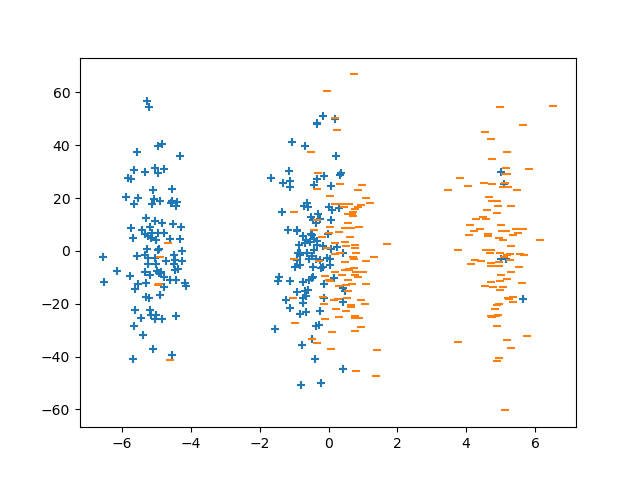

In [74]:
x_dim = 2
blobs_sizes = [100, 100, 100, 100]
blobs_labels = [1, -1, 1, -1]
blobs_means = torch.tensor([[-5, 0], [0.4, 0], [-0.4, 0], [5, 0]])
blobs_stds = torch.tensor([[0.5, 20] for i in range(4)])
blobs_noises = [0.05, 0, 0, 0.05]
X, y = gen_custom_normal_data2(x_dim, blobs_sizes, blobs_labels, blobs_means, blobs_stds, blobs_noises)
visualize_data2D(X, y)

path = "./experiments/varying_epsilon_experiments/final"
#save dataset
if not os.path.exists(path):
    os.makedirs(path)
torch.save(X, path + '/X.pt')
torch.save(y, path + '/y.pt')

In [76]:
lambdas = np.logspace(-2, 0, num=3).tolist()
epsilons = np.linspace(0, 0.5, num=6).tolist()
print(epsilons)
experiment_params = {"x_dim":2,
                    "N":30,
                    "epsilons":epsilons,
                    "train_size":200,
                    "test_size":5000,
                    "shift_range":1,
                    "scale_range":7,
                    "noise_frac":0,
                    "lambdas":lambdas,
                    "n_splits":3,
                    "lr":5e-2,
                    "batch_size":24,
                    "epochs":200}

results = varying_epsilons_experiment(**experiment_params)

now = datetime.now()
PATH = "./experiments/varying_epsilon_experiments/" + now.strftime("%d_%m_%Y__%H_%M_%S")
save_results(PATH, experiment_params, results)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5]
0.7832266666666665


 17%|█████████████▊                                                                     | 1/6 [09:36<48:02, 576.51s/it]

1.0 0.9736733333333334


 33%|███████████████████████████▋                                                       | 2/6 [18:40<37:09, 557.28s/it]

0.9 0.9245533333333334


 50%|█████████████████████████████████████████▌                                         | 3/6 [27:27<27:10, 543.47s/it]

0.8 0.8731933333333334


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [36:32<18:08, 544.23s/it]

0.7 0.8228866666666669


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [45:42<09:06, 546.35s/it]

0.6 0.7720733333333333


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [54:54<00:00, 549.10s/it]

0.5 0.7226266666666664
